In [6]:
import mindspore.nn as nn
from mindspore import  context
from mindspore import dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as VC
from mindspore.train import Model
from mindspore.train.callback import LossMonitor
from mindspore.nn import SoftmaxCrossEntropyWithLogits
from mindspore.nn import Accuracy
import numpy as np
from mindspore.train.callback import Callback
import matplotlib.pyplot as plt


from mindspore.train.callback import ModelCheckpoint, CheckpointConfig
import os


In [7]:
# 设置上下文
context.set_context(mode=context.GRAPH_MODE, device_target="GPU")

# 创建 CIFAR-10 数据集的加载函数
def create_cifar10_lstm_dataset(data_path, batch_size=32,device_target="GPU"):
    # 加载 CIFAR-10 数据集
    cifar_ds = ds.Cifar10Dataset(data_path)

    # 图像转换操作
    resize_op = VC.Resize((32, 32))
    rescale_op = VC.Rescale(1.0 / 255.0, 0.0)
    normalize_op = VC.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    hwc2chw_op = VC.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)
    # 应用图像预处理操作
    cifar_ds = cifar_ds.map(operations=[resize_op, rescale_op, normalize_op, hwc2chw_op], input_columns="image")
    cifar_ds = cifar_ds.map(operations=type_cast_op, input_columns="label")

    # 批处理并打乱
    cifar_ds = cifar_ds.shuffle(buffer_size=5000)
    cifar_ds = cifar_ds.batch(batch_size, drop_remainder=True)

    return cifar_ds

# 创建 LSTM 模型
class LSTMClassifier(nn.Cell):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Dense(hidden_size, num_classes)

    def construct(self, x):
        # 将图像展平到序列形式
        batch_size, channels, height, width = x.shape
        flattened_input_size = channels * height * width

        # 展平数据并将其转换为 LSTM 所期望的形状
        x = x.view(batch_size, -1, flattened_input_size)
        
        # LSTM 前向传播
        lstm_out, _ = self.lstm(x)

        # 取最后一个时间步的输出进行分类
        output = self.fc(lstm_out[:, -1, :])

        return output

class StepLossAccInfo(Callback):
    def __init__(self, model, eval_dataset, steps_loss, steps_eval):
        self.model = model
        self.eval_dataset = eval_dataset
        self.steps_loss = steps_loss
        self.steps_eval = steps_eval

    def step_end(self, run_context):
        cb_params = run_context.original_args()
        # cur_epoch = cb_params.cur_epoch_num
        # cur_step = (cur_epoch-1)*1562 + cb_params.cur_step_num
        cur_step = cb_params.cur_step_num
        if cur_step % 10 == 0:
            self.steps_loss["loss_value"].append(str(cb_params.net_outputs))
            self.steps_loss["step"].append(str(cur_step))
        if cur_step % 100 == 0:
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.steps_eval["step"].append(cur_step)
            self.steps_eval["acc"].append(acc["Accuracy"])

In [8]:
# 创建训练数据集
train_data_path = "./datasets/cifar10/train/"
train_dataset = create_cifar10_lstm_dataset(train_data_path)

test_data_path = "./datasets/cifar10/test/"

test_dataset = create_cifar10_lstm_dataset(train_data_path)

begin training...
epoch: 1 step: 200, loss is 2.084407329559326
epoch: 1 step: 400, loss is 2.1845991611480713
epoch: 1 step: 600, loss is 2.1109912395477295
epoch: 1 step: 800, loss is 1.9606157541275024
epoch: 1 step: 1000, loss is 1.9921693801879883
epoch: 1 step: 1200, loss is 2.004951000213623
epoch: 1 step: 1400, loss is 1.851112961769104
epoch: 2 step: 38, loss is 1.8308087587356567
epoch: 2 step: 238, loss is 1.689967155456543
epoch: 2 step: 438, loss is 1.959431529045105
epoch: 2 step: 638, loss is 2.0635018348693848
epoch: 2 step: 838, loss is 1.9001340866088867
epoch: 2 step: 1038, loss is 1.734214186668396
epoch: 2 step: 1238, loss is 1.7157057523727417
epoch: 2 step: 1438, loss is 2.4261059761047363
epoch: 3 step: 76, loss is 1.7346678972244263
epoch: 3 step: 276, loss is 1.8010642528533936
epoch: 3 step: 476, loss is 1.614302396774292
epoch: 3 step: 676, loss is 1.755729079246521
epoch: 3 step: 876, loss is 1.688529133796692
epoch: 3 step: 1076, loss is 1.9572041034698486

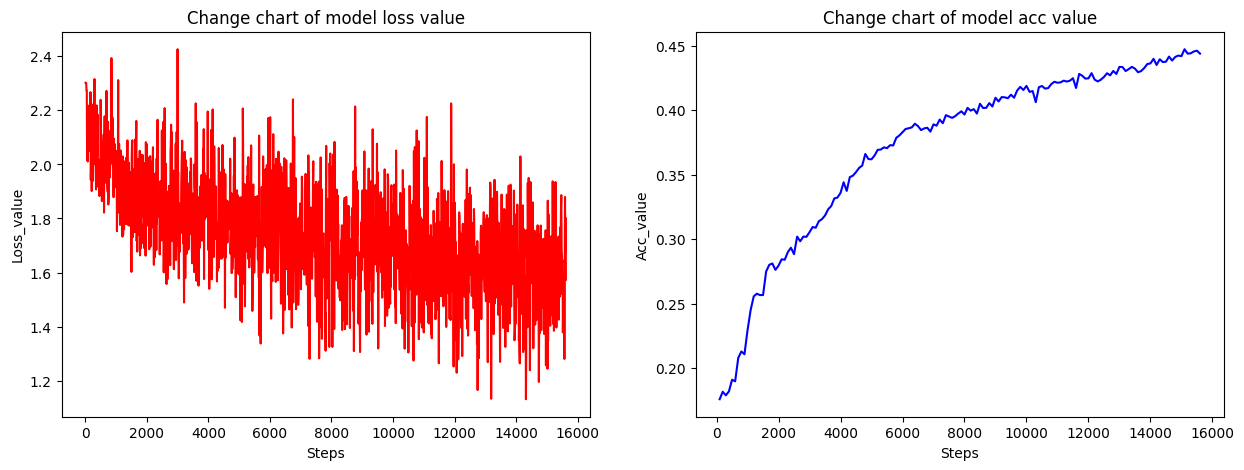

In [9]:
'''
任务四补全
'''
# 实例化 LSTM 模型
net=LSTMClassifier(3072,100,5,10)
# 定义损失函数和优化器
loss_func = SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
optimizer = nn.Adam(net.trainable_params(), learning_rate=1e-3)

# 创建模型
model = Model(net, loss_fn=loss_func, optimizer=optimizer, metrics={"Accuracy": Accuracy()})
# 训练模型
epoch_size = 10

# 设置模型保存的路径，删除掉之前训练保存的模型
model_path = "./models/ckpt/mindspore_vision_application/"
os.system('rm -f {0}*.ckpt {0}*.meta {0}*.pb'.format(model_path))
# 得到每个batch的训练步数
batch_num = train_dataset.get_dataset_size()
# 设置与模型保存相关的参数
net_type = 'LSTM'
config_ck = CheckpointConfig(save_checkpoint_steps=batch_num, keep_checkpoint_max=1)
ckpoint_cb = ModelCheckpoint(prefix="train_" + net_type + "_cifar10", directory=model_path, config=config_ck)
# 设置损失记录器，参数是打印Loss信息的步长
loss_cb = LossMonitor(200)
# 设置记录损失的数据结构，用于在后面打印曲线图像
steps_loss = {"step": [], "loss_value": []}
steps_eval = {"step": [], "acc": []}
step_loss_acc_info = StepLossAccInfo(model, test_dataset, steps_loss, steps_eval)
# 执行模型的训练
print("begin training...")
model.train(epoch_size, train_dataset, callbacks=[ckpoint_cb, loss_cb, step_loss_acc_info], dataset_sink_mode=False)
# model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, loss_cb, step_loss_acc_info])
# 训练完后，对模型进行测试，打印正确率
res = model.eval(test_dataset)
print("result: ", res)
# 利用训练中保存的信息，打印训练损失曲线和训练正确率曲线
steps = steps_loss["step"]
loss_value = steps_loss["loss_value"]
steps = list(map(int, steps))
loss_value = list(map(float, loss_value))
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, loss_value, color="red")
plt.xlabel("Steps")
plt.ylabel("Loss_value")
plt.title("Change chart of model loss value")
steps = steps_eval["step"]
acc_value = steps_eval["acc"]
steps = list(map(int, steps))
loss_value = list(map(float, acc_value))
plt.subplot(1, 2, 2)
plt.plot(steps, acc_value, color="blue")
plt.xlabel("Steps")
plt.ylabel("Acc_value")
plt.title("Change chart of model acc value")
plt.show()



In [ ]:
#加载数据集
